In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple

import os
from pathlib import Path
import re
import json
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt


## Utils

In [2]:


# Contract
# inputs: dict model_name -> path (folder containing per-assay CSVs or nested)
# outputs: DataFrame (rows=models, cols=assays), long-form DataFrame for plotting
# error modes: missing columns, empty CSVs, mismatched lengths handled gracefully

ASSAY_ID_COL_CANDIDATES = [
    'DMS_id', 'Assay', 'assay', 'assay_id'
]
TRUTH_COL_CANDIDATES = [
    'DMS_score', 'ground_truth', 'y', 'fitness', 'label'
]
# Model score column will be inferred per CSV based on presence of columns other than standard ones.

CSV_GLOB = r"**/*.csv"


def _infer_assay_id(df: pd.DataFrame, default_from_path: str) -> str:
    for c in ASSAY_ID_COL_CANDIDATES:
        if c in df.columns and pd.api.types.is_string_dtype(df[c]):
            vals = df[c].dropna().unique()
            if len(vals) == 1:
                return str(vals[0])
    # fallback to filename stem
    return default_from_path


def _find_truth_col(df: pd.DataFrame) -> str:
    for c in TRUTH_COL_CANDIDATES:
        if c in df.columns and np.issubdtype(df[c].dtype, np.number):
            return c
    # Also try "DMS_score_Binarized" seen in some exports
    for c in df.columns:
        if c.lower() in {"dms_score", "dms_score_binarized", "true", "target"} and np.issubdtype(df[c].dtype, np.number):
            return c
    raise ValueError("No numeric ground-truth column found in candidates.")


def _find_model_score_cols(df: pd.DataFrame) -> List[str]:
    # Heuristic: numeric columns that are not index-like and not truth
    numeric_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    truth = set([_find_truth_col(df)]) if any(c in df.columns for c in TRUTH_COL_CANDIDATES) else set()
    ignore = set(['position', 'pos', 'i', 'j', 'k']) | truth
    score_cols = [c for c in numeric_cols if c not in ignore]
    return score_cols


def iter_assay_csvs(root: Path) -> List[Path]:
    return sorted([p for p in root.glob(CSV_GLOB) if p.is_file()])


# ---- Caching-enabled Spearman computation (mirrors proseqo notebook) ----

def compute_spearman_for_file(model_name: str, csv_path: Path):
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        return None
    if df.empty:
        return None
    try:
        truth_col = _find_truth_col(df)
    except Exception:
        return None
    assay_id = _infer_assay_id(df, default_from_path=csv_path.stem)
    score_cols = _find_model_score_cols(df)
    if not score_cols:
        return None
    chosen = None
    for c in score_cols:
        if model_name == c or model_name in c:
            chosen = c
            break
    if chosen is None:
        chosen = [c for c in score_cols if c != truth_col][-1] if len(score_cols) > 1 else score_cols[0]
    x = df[truth_col].astype(float)
    y = df[chosen].astype(float)
    if len(x) < 2:
        return None
    rho = spearmanr(x, y, nan_policy='omit').correlation
    if pd.isna(rho):
        return None
    return {"stem": csv_path.stem, "assay": str(assay_id), "spearman": float(rho)}


def compute_spearman_per_assay(model_name: str, model_root: Path) -> List[Tuple[str, float]]:
    # Backward-compatible full recompute
    results: List[Tuple[str, float]] = []
    for csv_path in iter_assay_csvs(model_root):
        rec = compute_spearman_for_file(model_name, csv_path)
        if rec is not None:
            results.append((rec["assay"], rec["spearman"]))
    return results


def _cache_dir(root: Path) -> Path:
    cd = root / "_analysis_cache"
    cd.mkdir(exist_ok=True, parents=True)
    return cd


def _cache_file_for_model(root: Path, model_name: str) -> Path:
    # safe filename
    safe = re.sub(r"[^A-Za-z0-9_.-]", "_", model_name)
    return _cache_dir(root) / f"spearman_{safe}.csv"


def load_cached_spearman_full(root: Path, model_name: str):
    f = _cache_file_for_model(root, model_name)
    if f.exists():
        try:
            cdf = pd.read_csv(f)
            if {'assay','spearman'}.issubset(set(cdf.columns)):
                cdf['assay'] = cdf['assay'].astype(str)
                if 'stem' in cdf.columns:
                    cdf['stem'] = cdf['stem'].astype(str)
                return cdf
        except Exception:
            return None
    return None


def save_cached_spearman_df(root: Path, model_name: str, cdf: pd.DataFrame) -> None:
    f = _cache_file_for_model(root, model_name)
    cols = ['stem','assay','spearman'] if 'stem' in cdf.columns else ['assay','spearman']
    cdf.loc[:, cols].to_csv(f, index=False)


def evaluate_models(model_paths: Dict[str, str], public_benchmark: pd.DataFrame, *, recompute: bool = False, cache_root: Path | None = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    wide = {}
    long_rows = []
    base_root = cache_root if cache_root is not None else Path.cwd()
    for name, path in model_paths.items():
        if path == "precomputed":
            # Look for model name in public benchmark
            if name in public_benchmark.columns:
                for assay in public_benchmark.index:
                    rho = public_benchmark.loc[assay, name]
                    if not pd.isna(rho):
                        wide.setdefault(name, {})[assay] = rho
                        long_rows.append({"model": name, "assay": assay, "spearman": rho})
        else:
            root = Path(path)
            expected_stems = [p.stem for p in iter_assay_csvs(root)]
            cdf = None if recompute else load_cached_spearman_full(root, name)
            if cdf is None or cdf.empty:
                # No usable cache: compute all
                rows = []
                for csv_path in iter_assay_csvs(root):
                    rec = compute_spearman_for_file(name, csv_path)
                    if rec is not None:
                        rows.append(rec)
                cdf = pd.DataFrame(rows, columns=["stem","assay","spearman"]) if rows else pd.DataFrame(columns=["stem","assay","spearman"])
                save_cached_spearman_df(root, name, cdf)
            else:
                # Cache exists: verify completeness by file stem
                cached_stems = set(cdf["stem"].astype(str)) if "stem" in cdf.columns else set(cdf["assay"].astype(str))
                missing = [s for s in expected_stems if s not in cached_stems]
                if missing:
                    new_rows = []
                    for csv_path in iter_assay_csvs(root):
                        if csv_path.stem in missing:
                            rec = compute_spearman_for_file(name, csv_path)
                            if rec is not None:
                                new_rows.append(rec)
                    if new_rows:
                        new_df = pd.DataFrame(new_rows)
                        if "stem" not in cdf.columns:
                            cdf["stem"] = cdf["assay"]
                        cdf = pd.concat([cdf, new_df], ignore_index=True)
                        cdf = cdf.drop_duplicates(subset=["stem"], keep="first")
                        save_cached_spearman_df(root, name, cdf)
            # Fill outputs from cache (complete or completed)
            pairs = [(str(a), float(r)) for a, r in zip(cdf["assay"], cdf["spearman"]) ]
            wide[name] = {assay: rho for assay, rho in pairs}
            for assay, rho in pairs:
                long_rows.append({"model": name, "assay": assay, "spearman": rho})
    wide_df = pd.DataFrame(wide).T.sort_index()
    long_df = pd.DataFrame(long_rows)
    return wide_df, long_df

In [3]:
# Display settings
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.rcParams['figure.dpi'] = 120
sns.set_theme(style='whitegrid')

# Analyze ProteinGym DMS zero-shot results
This notebook loads per-assay CSVs from one or more model result folders, computes Spearman correlations against ground truth for each assay, aggregates into a models×assays table, and visualizes distributions with a violin plot.

In [ ]:
# Define your models here: { name: folder_with_csvs }
# Example:
# model_paths = {
#     "AMPLIFY-large": "/path/to/outputs/AMPLIFY-large",
#     "AnotherModel": "/path/to/outputs/AnotherModel"
# }
model_paths = {
    "AMPLIFY_350M": "/network/scratch/d/david.heurtel-depeiges/proteingym/results/zero_shot_substitutions_scores/AMPLIFY/350M_hf_mm",
    "AMPLIFY_120M": "/network/scratch/d/david.heurtel-depeiges/proteingym/results/zero_shot_substitutions_scores/AMPLIFY/120M_hf_mm",
    "AMPLIFY_120M_base": "/network/scratch/d/david.heurtel-depeiges/proteingym/results/zero_shot_substitutions_scores/AMPLIFY/120Mbase_hf_mm",
    "ESM2 (8M)": "precomputed",
    "ESM2 (35M)": "precomputed",
    "ESM2 (150M)" : "precomputed",
    "ESM2 (650M)" : "precomputed",
    "ESM2 (3B)" : "precomputed",
    "ESM2 (15B)" : "precomputed",
    # "myESM2_8M": "/network/scratch/d/david.heurtel-depeiges/proteingym/results/zero_shot_substitutions_scores/ESM2/8M_hf_mm",
    "SaESM2_650M": "/network/scratch/d/david.heurtel-depeiges/proteingym/results/zero_shot_substitutions_scores/SaESM2/650M_hf_mm",
    "SaESM2_150M": "/network/scratch/d/david.heurtel-depeiges/proteingym/results/zero_shot_substitutions_scores/SaESM2/150M_local_mm",
    "SaESM2_35M": "/network/scratch/d/david.heurtel-depeiges/proteingym/results/zero_shot_substitutions_scores/SaESM2/35M_local_mm",
    "SaESM2_8M": "/network/scratch/d/david.heurtel-depeiges/proteingym/results/zero_shot_substitutions_scores/SaESM2/8M_local_mm",
    "SaAMPLIFY_350M": "/network/scratch/d/david.heurtel-depeiges/proteingym/results/zero_shot_substitutions_scores/SaAMPLIFY/350M_hf_mm",
    "SaAMPLIFY_120M": "/network/scratch/d/david.heurtel-depeiges/proteingym/results/zero_shot_substitutions_scores/SaAMPLIFY/120M_hf_mm",
    # Add more models as needed
}

colors = {
    "AMPLIFY_350M": "#1f77b4",  # blue
    "AMPLIFY_120M": "#aec7e8",  # lighter blue
    "AMPLIFY_120M_base": "#595f6c",  # blue gray
    "ESM2 (8M)": "#ffcc80",      # light orange
    "ESM2 (35M)": "#ff9f40",     # medium-light orange  
    "ESM2 (150M)": "#ff8f00",    # medium orange
    "ESM2 (650M)": "#ff6f00",    # medium-dark orange
    "ESM2 (3B)": "#e65100",      # dark orange
    "ESM2 (15B)": "#bf360c",     # very dark orange
    # "myESM2_8M": "#7efa5f",      # light green 
    "SaESM2_650M": "#1b5e20",     # deep forest/olive green (darkest, heaviest)
    "SaESM2_150M": "#2e7d32",     # dark green-olive
    "SaESM2_35M":  "#43a047",     # medium emerald green
    "SaESM2_8M":   "#66c2a5",     # teal-green, darker than before
    "SaAMPLIFY_350M": "#b433ff",    # light purple
    "SaAMPLIFY_120M": "#d580ff",    # lighter purple
    # Add more colors as needed
}

model_sizes = { # In Millions of parameters
    "AMPLIFY_350M": 350,
    "AMPLIFY_120M": 120,
    "AMPLIFY_120M_base": 120,
    "ESM2 (8M)": 8,
    "ESM2 (35M)": 35,
    "ESM2 (150M)" : 150,
    "ESM2 (650M)" : 650,
    "ESM2 (3B)" : 3000,
    "ESM2 (15B)" : 15000,
    # "myESM2_8M": 8
    # Add more model sizes as needed
    "SaESM2_650M": 650,
    "SaESM2_150M": 150,
    "SaESM2_35M": 35,
    "SaESM2_8M": 8,
    "SaAMPLIFY_350M": 350,
    "SaAMPLIFY_120M": 120,
}

model_families = {
    "AMPLIFY": ["AMPLIFY_350M", "AMPLIFY_120M"],
    "AMPLIFY_base": [],
    "SaAMPLIFY": ["SaAMPLIFY_350M", "SaAMPLIFY_120M"],
    "ESM2": ["ESM2 (35M)", "ESM2 (150M)", "ESM2 (650M)", "ESM2 (3B)", "ESM2 (15B)", "ESM2 (8M)"],
    # "myESM2": ["myESM2_8M"],
    "SaESM2": ["SaESM2_650M", "SaESM2_150M", "SaESM2_35M", "SaESM2_8M"],
    # Add more model families as needed
}

In [5]:
# Load the previous results (all other public models)
repo_root = Path.cwd().parent
dms_substitutions_df = pd.read_csv(repo_root / "benchmarks/DMS_zero_shot/substitutions/Spearman/DMS_substitutions_Spearman_DMS_level.csv", index_col=0)

In [6]:
dms_substitutions_df.head() # Structure is index is DMS id, columsn are model names

,Site-Independent,EVmutation,DeepSequence (single),DeepSequence (ensemble),EVE (single),EVE (ensemble),Unirep,Unirep evotuned,MSA Transformer (single),MSA Transformer (ensemble),ESM-1b,ESM-1v (single),ESM-1v (ensemble),ESM2 (8M),ESM2 (35M),ESM2 (150M),ESM2 (650M),ESM2 (3B),ESM2 (15B),Wavenet,RITA S,RITA M,RITA L,RITA XL,Progen2 S,Progen2 M,Progen2 Base,Progen2 L,Progen2 XL,GEMME,VESPA,VESPAl,VespaG,ProtGPT2,Tranception S no retrieval,Tranception M no retrieval,Tranception L no retrieval,Tranception S,Tranception M,Tranception L,TranceptEVE S,TranceptEVE M,TranceptEVE L,CARP (38M),CARP (600K),CARP (640M),CARP (76M),MIF,MIF-ST,ESM-IF1,ProteinMPNN,"ProtSSN (k=10, h=512)","ProtSSN (k=10, h=768)","ProtSSN (k=10, h=1280)","ProtSSN (k=20, h=512)","ProtSSN (k=20, h=768)","ProtSSN (k=20, h=1280)","ProtSSN (k=30, h=512)","ProtSSN (k=30, h=768)","ProtSSN (k=30, h=1280)",ProtSSN (ensemble),SaProt (650M),SaProt (35M),PoET (200M),MULAN,ProSST (K=20),ProSST (K=128),ProSST (K=512),ProSST (K=1024),ProSST (K=2048),ProSST (K=4096),ESCOTT,VenusREM,RSALOR,S2F,S2F-MSA,S3F,S3F-MSA,SiteRM,ESM3 open (1.4B),ESM-C (300M),ESM-C (600M),xTrimoPGLM-1B-MLM,xTrimoPGLM-3B-MLM,xTrimoPGLM-10B-MLM,xTrimoPGLM-1B-CLM,xTrimoPGLM-3B-CLM,xTrimoPGLM-7B-CLM,xTrimoPGLM-100B-int4,Progen3 112m,Progen3 219m,Progen3 339m,Progen3 762m,Progen3 1B,Progen3 3B,AIDO Protein-RAG (16B),Protriever,Number of Mutants,Selection Type,UniProt ID,MSA_Neff_L_category,Taxon
DMS ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A0A140D2T1_ZIKV_Sourisseau_2019,0.383,0.354,0.131,0.103,0.394,0.405,-0.133,0.062,0.436,0.439,-0.001,-0.048,0.015,-0.073,-0.054,-0.058,0.213,0.363,0.375,0.216,0.361,0.309,0.317,0.305,0.329,0.342,0.328,0.312,0.293,0.430,0.319,0.296,0.380,0.005,0.304,0.331,0.272,0.362,0.366,0.351,0.361,0.358,0.373,-0.060,-0.073,0.131,-0.061,0.273,0.290,0.287,0.129,0.253,0.251,0.282,0.296,0.277,0.269,0.263,0.269,0.265,0.278,0.199,0.116,0.429,0.071,0.107,0.102,0.113,0.113,0.280,0.112,0.471,0.387,0.423,0.285,0.402,0.308,0.418,0.415,0.277,-0.058,-0.048,-0.048,0.366,0.373,0.332,0.282,-0.024,0.303,0.032,0.191,0.305,0.298,0.354,0.338,0.427,0.477,9576,OrganismalFitness,A0A140D2T1_ZIKV,Medium,Virus
A0A192B1T2_9HIV1_Haddox_2018,0.481,0.407,0.413,0.432,0.509,0.516,0.000,0.513,0.511,0.515,0.456,0.492,0.516,-0.003,0.015,0.035,0.080,0.132,0.164,0.465,0.496,0.507,0.509,0.505,0.497,0.501,0.463,0.490,0.484,0.496,0.541,0.507,0.299,0.327,0.492,0.483,0.514,0.509,0.503,0.513,0.524,0.518,0.528,0.422,-0.021,0.497,0.429,0.329,0.451,0.206,0.136,0.202,0.230,0.258,0.263,0.210,0.226,0.228,0.200,0.183,0.239,0.173,0.084,0.488,0.051,0.341,0.383,0.382,0.404,0.447,0.419,0.522,0.562,0.532,0.307,0.523,0.365,0.552,0.515,0.257,0.478,0.460,0.488,0.521,0.466,0.476,0.332,0.024,0.334,0.409,0.482,0.471,0.473,0.487,0.499,0.595,0.504,12577,OrganismalFitness,A0A192B1T2_9HIV1,Medium,Virus
A0A1I9GEU1_NEIME_Kennouche_2019,-0.011,0.044,0.107,0.098,0.053,0.054,-0.024,0.084,0.082,0.077,0.040,0.068,0.068,-0.037,-0.047,-0.016,0.030,0.027,0.025,0.067,-0.010,0.047,0.071,0.088,0.050,0.088,0.080,0.089,0.095,0.045,0.046,0.036,0.033,0.030,0.036,0.055,0.099,0.031,0.041,0.057,0.058,0.061,0.075,-0.055,-0.056,0.039,-0.043,0.051,0.055,0.039,0.040,0.054,0.042,0.039,0.035,0.037,0.052,0.039,0.058,0.041,0.047,0.040,-0.005,0.057,-0.016,0.146,0.177,0.199,0.176,0.076,0.182,0.041,0.070,-0.010,0.043,0.055,0.049,0.058,0.061,0.025,0.058,0.051,0.042,0.051,0.053,0.061,0.020,0.037,0.065,-0.019,0.008,0.043,0.059,0.088,0.094,0.064,0.056,922,Activity,A0A1I9GEU1_NEIME,Medium,Prokaryote
A0A247D711_LISMN_Stadelmann_2021,0.436,0.459,0.109,0.041,0.428,0.428,0.003,0.026,0.299,0.320,0.087,0.088,0.093,0.064,0.084,0.097,0.066,0.084,0.084,0.059,0.021,0.015,0.040,0.078,-0.029,0.067,0.010,0.037,0.106,0.473,0.337,0.351,0.382,0.093,0.041,0.024,0.057,0.301,0.292,0.311,0.253,0.242,0.263,0.047,0.002,0.074,0.084,0.418,0.441,0.476,0.364,0.274,0.326,0.314,0.344,0.313,0.360,0.312,0.331,0.265,0.335,0.427,0.280,0.458,0.162,0.450,0.476,0

In [7]:
if not model_paths:
    print("Please set 'model_paths' to your result folders (each containing per-assay CSVs).")
else:
    # Toggle recompute to True to force refresh of cached per-assay Spearman scores
    recompute = False
    wide_df, long_df = evaluate_models(model_paths, dms_substitutions_df, recompute=recompute)
    display(wide_df)
    print(f"Total assays with results: {long_df['assay'].nunique()} across {long_df['model'].nunique()} models")

,A0A140D2T1_ZIKV_Sourisseau_2019,A0A192B1T2_9HIV1_Haddox_2018,A0A1I9GEU1_NEIME_Kennouche_2019,A0A247D711_LISMN_Stadelmann_2021,A0A2Z5U3Z0_9INFA_Doud_2016,A0A2Z5U3Z0_9INFA_Wu_2014,A4D664_9INFA_Soh_2019,A4GRB6_PSEAI_Chen_2020,A4_HUMAN_Seuma_2022,AACC1_PSEAI_Dandage_2018,ACE2_HUMAN_Chan_2020,ADRB2_HUMAN_Jones_2020,AICDA_HUMAN_Gajula_2014_3cycles,AMFR_HUMAN_Tsuboyama_2023_4G3O,AMIE_PSEAE_Wrenbeck_2017,ANCSZ_Hobbs_2022,ARGR_ECOLI_Tsuboyama_2023_1AOY,B2L11_HUMAN_Dutta_2010_binding-Mcl-1,BBC1_YEAST_Tsuboyama_2023_1TG0,BCHB_CHLTE_Tsuboyama_2023_2KRU,BLAT_ECOLX_Deng_2012,BLAT_ECOLX_Firnberg_2014,BLAT_ECOLX_Jacquier_2013,BLAT_ECOLX_Stiffler_2015,BRCA1_HUMAN_Findlay_2018,BRCA2_HUMAN_Erwood_2022_HEK293T,C6KNH7_9INFA_Lee_2018,CALM1_HUMAN_Weile_2017,CAPSD_AAV2S_Sinai_2021,CAR11_HUMAN_Meitlis_2020_gof,CAR11_HUMAN_Meitlis_2020_lof,CAS9_STRP1_Spencer_2017_positive,CASP3_HUMAN_Roychowdhury_2020,CASP7_HUMAN_Roychowdhury_2020,CATR_CHLRE_Tsuboyama_2023_2AMI,CBPA2_HUMAN_Tsuboyama_2023_1O6X,CBS_HUMAN_Sun_2020,CBX4_HUMAN_Tsuboyama_2023_2K28,CCDB_ECOLI_Adkar_2012,CCDB_ECOLI_Tripathi_2016,CCR5_HUMAN_Gill_2023,CD19_HUMAN_Klesmith_2019_FMC_singles,CP2C9_HUMAN_Amorosi_2021_abundance,CP2C9_HUMAN_Amorosi_2021_activity,CSN4_MOUSE_Tsuboyama_2023_1UFM,CUE1_YEAST_Tsuboyama_2023_2MYX,D7PM05_CLYGR_Somermeyer_2022,DLG4_HUMAN_Faure_2021,DLG4_RAT_McLaughlin_2012,DN7A_SACS2_Tsuboyama_2023_1JIC,DNJA1_HUMAN_Tsuboyama_2023_2LO1,DOCK1_MOUSE_Tsuboyama_2023_2M0Y,DYR_ECOLI_Nguyen_2023,DYR_ECOLI_Thompson_2019,ENVZ_ECOLI_Ghose_2023,ENV_HV1B9_DuenasDecamp_2016,ENV_HV1BR_Haddox_2016,EPHB2_HUMAN_Tsuboyama_2023_1F0M,ERBB2_HUMAN_Elazar_2016,ESTA_BACSU_Nutschel_2020,F7YBW8_MESOW_Aakre_2015,F7YBW8_MESOW_Ding_2023,FECA_ECOLI_Tsuboyama_2023_2D1U,FKBP3_HUMAN_Tsuboyama_2023_2KFV,GAL4_YEAST_Kitzman_2015,GCN4_YEAST_Staller_2018,GDIA_HUMAN_Silverstein_2021,GFP_AEQVI_Sarkisyan_2016,GLPA_HUMAN_Elazar_2016,GRB2_HUMAN_Faure_2021,HCP_LAMBD_Tsuboyama_2023_2L6Q,HECD1_HUMAN_Tsuboyama_2023_3DKM,HEM3_HUMAN_Loggerenberg_2023,HIS7_YEAST_Pokusaeva_2019,HMDH_HUMAN_Jiang_2019,HSP82_YEAST_Cote-Hammarlof_2020_growth-H2O2,HSP82_YEAST_Flynn_2019,HSP82_YEAST_Mishra_2016,HXK4_HUMAN_Gersing_2022_activity,HXK4_HUMAN_Gersing_2023_abundance,I6TAH8_I68A0_Doud_2015,IF1_ECOLI_Kelsic_2016,ILF3_HUMAN_Tsuboyama_2023_2L33,ISDH_STAAW_Tsuboyama_2023_2LHR,KCNE1_HUMAN_Muhammad_2023_expression,KCNE1_HUMAN_Muhammad_2023_function,KCNH2_HUMAN_Kozek_2020,KCNJ2_MOUSE_Coyote-Maestas_2022_function,KCNJ2_MOUSE_Coyote-Maestas_2022_surface,KKA2_KLEPN_Melnikov_2014,LGK_LIPST_Klesmith_2015,LYAM1_HUMAN_Elazar_2016,MAFG_MOUSE_Tsuboyama_2023_1K1V,MBD11_ARATH_Tsuboyama_2023_6ACV,MET_HUMAN_Estevam_2023,MK01_HUMAN_Brenan_2016,MLAC_ECOLI_MacRae_2023,MSH2_HUMAN_Jia_2020,MTH3_HAEAE_RockahShmuel_2015,MTHR_HUMAN_Weile_2021,...,P53_HUMAN_Giacomelli_2018_Null_Nutlin,P53_HUMAN_Giacomelli_2018_WT_Nutlin,P53_HUMAN_Kotler_2018,P84126_THETH_Chan_2017,PABP_YEAST_Melamed_2013,PAI1_HUMAN_Huttinger_2021,PA_I34A1_Wu_2015,PHOT_CHLRE_Chen_2023,PIN1_HUMAN_Tsuboyama_2023_1I6C,PITX2_HUMAN_Tsuboyama_2023_2L7M,PKN1_HUMAN_Tsuboyama_2023_1URF,POLG_CXB3N_Mattenberger_2021,POLG_DEN26_Suphatrakul_2023,POLG_HCVJF_Qi_2014,POLG_PESV_Tsuboyama_2023_2MXD,PPARG_HUMAN_Majithia_2016,PPM1D_HUMAN_Miller_2022,PR40A_HUMAN_Tsuboyama_2023_1UZC,PRKN_HUMAN_Clausen_2023,PSAE_PICP2_Tsuboyama_2023_1PSE,PTEN_HUMAN_Matreyek_2021,PTEN_HUMAN_Mighell_2018,Q2N0S5_9HIV1_Haddox_2018,Q53Z42_HUMAN_McShan_2019_binding-TAPBPR,Q53Z42_HUMAN_McShan_2019_expression,Q59976_STRSQ_Romero_2015,Q6WV12_9MAXI_Somermeyer_2022,Q837P4_ENTFA_Meier_2023,Q837P5_ENTFA_Meier_2023,Q8WTC7_9CNID_Somermeyer_2022,R1AB_SARS2_Flynn_2022,RAD_ANTMA_Tsuboyama_2023_2CJJ,RAF1_HUMAN_Zinkus-Boltz_2019,RASH_HUMAN_Bandaru_2017,RASK_HUMAN_Weng_2022_abundance,RASK_HUMAN_Weng_2022_binding-DARPin_K55,RBP1_HUMAN_Tsuboyama_2023_2KWH,RCD1_ARATH_Tsuboyama_2023_5OAO,RCRO_LAMBD_Tsuboyama_2023_1ORC,RD23A_HUMAN_Tsuboyama_2023_1IFY,RDRP_I33A0_Li_2023,REV_HV1H2_Fernandes_2016,RFAH_ECOLI_Tsuboyama_2023_2LCL,RL20_AQUAE_Tsuboyama_2023_1GYZ,RL40A_YEAST_M

Total assays with results: 217 across 15 models


/tmp/ipykernel_3052956/1726562990.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=long_df_ordered, y='spearman', x='model', inner='box', cut=0, palette=colors)


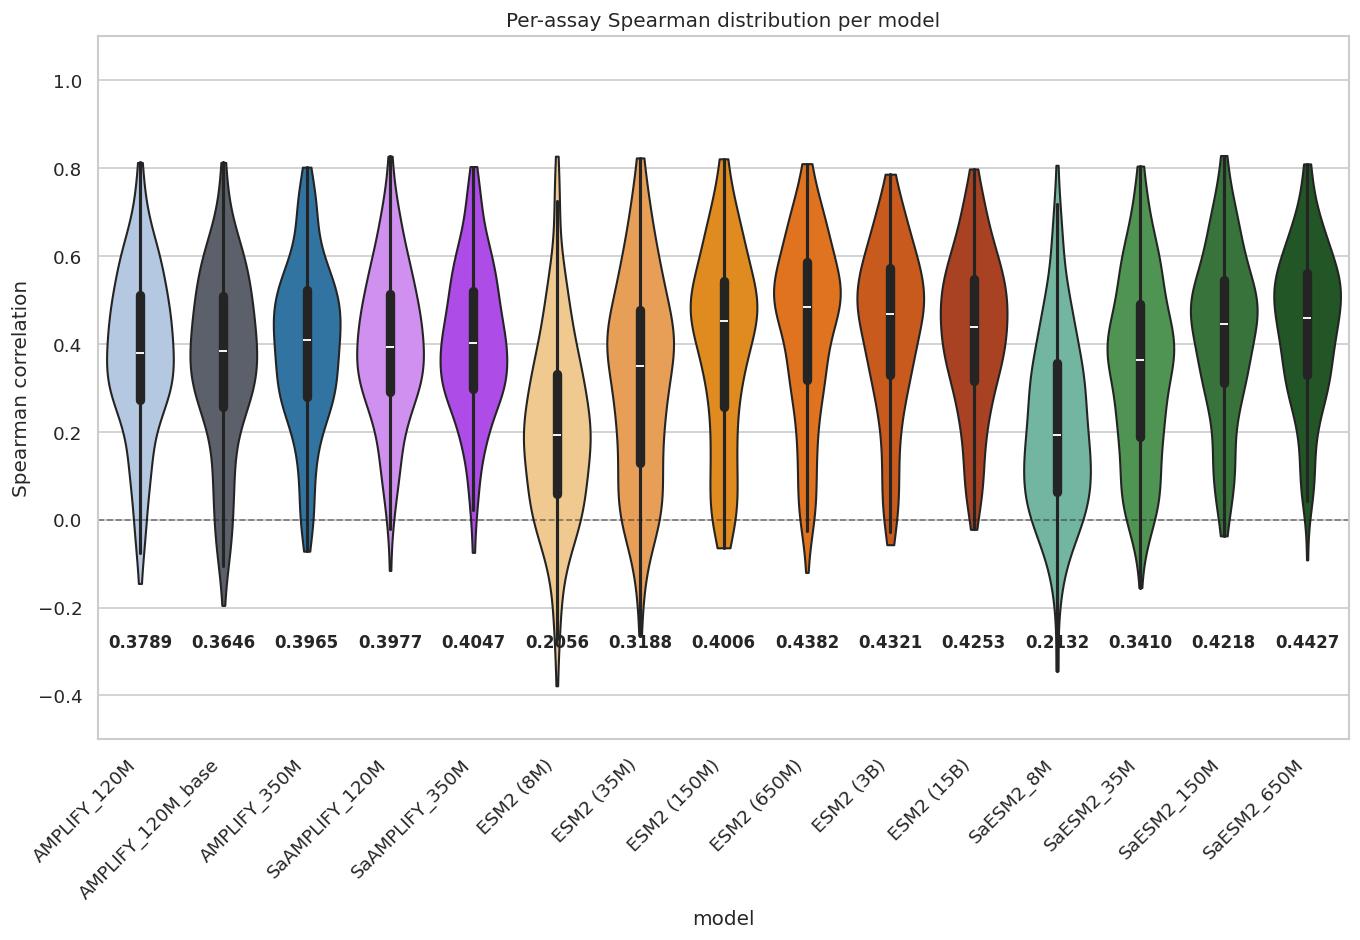

In [8]:
# Violin plot comparing models
if 'long_df' in globals() and not long_df.empty:
    # Create custom ordering by family and model size
    ordered_models = []
    for family, models in model_families.items():
        # Filter models that exist in the data and have size info
        family_models = [m for m in models if m in long_df['model'].unique() and m in model_sizes]
        # Sort by model size within family
        family_models.sort(key=lambda x: model_sizes[x])
        ordered_models.extend(family_models)
    
    # Reorder the dataframe
    long_df_ordered = long_df[long_df['model'].isin(ordered_models)].copy()
    long_df_ordered['model'] = pd.Categorical(long_df_ordered['model'], categories=ordered_models, ordered=True)
    
    plt.figure(figsize=(4 + 0.5*len(ordered_models), 8))
    ax = sns.violinplot(data=long_df_ordered, y='spearman', x='model', inner='box', cut=0, palette=colors)
    ax.axhline(0.0, color='k', lw=1, ls='--', alpha=0.5)
    ax.set_ylim(-0.5, 1.1)  # Adjusted based on your data range
    
    # Add mean values as text on the plot
    for i, model in enumerate(ordered_models):
        model_data = long_df_ordered[long_df_ordered['model'] == model]['spearman']
        if not model_data.empty:
            mean_val = model_data.mean()
            ax.text(i, -0.3, f'{mean_val:.4f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_title('Per-assay Spearman distribution per model')
    ax.set_ylabel('Spearman correlation')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot. Fill 'model_paths' and run the evaluation cell above first.")

In [9]:
# Optional: save results
if 'wide_df' in globals() and 'long_df' in globals() and not long_df.empty:
    out_dir = Path.cwd()
    wide_path = out_dir / 'spearman_wide.csv'
    long_path = out_dir / 'spearman_long.csv'
    wide_df.to_csv(wide_path)
    long_df.to_csv(long_path, index=False)
    print(f"Saved: {wide_path}\nSaved: {long_path}")
else:
    print("Nothing to save yet.")

Saved: /home/mila/d/david.heurtel-depeiges/ProteinGym/notebooks/spearman_wide.csv
Saved: /home/mila/d/david.heurtel-depeiges/ProteinGym/notebooks/spearman_long.csv


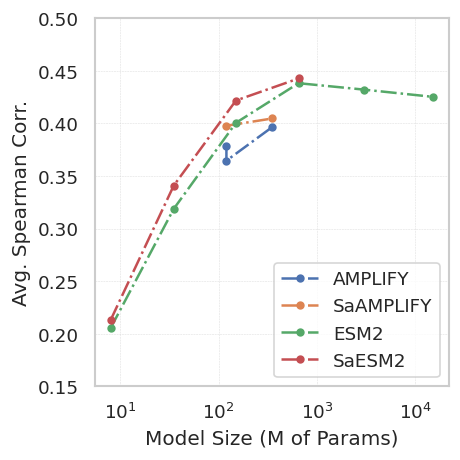

In [10]:
# Plot the average performance vs model size for each model family 

if 'long_df' in globals() and not long_df.empty and model_sizes and model_families:
    plt.figure(figsize=(4, 4))
    for family, models in model_families.items():
        family_data = long_df[long_df['model'].isin(models)]
        avg_per_model = family_data.groupby('model')['spearman'].mean().reset_index()
        avg_per_model['size'] = avg_per_model['model'].map(model_sizes)
        avg_per_model = avg_per_model.dropna(subset=['size'])
        # Sort by model size
        avg_per_model = avg_per_model.sort_values('size')
        if not avg_per_model.empty:
            plt.plot(avg_per_model['size'],
                    avg_per_model['spearman'], 
                    marker='o', 
                    linestyle='-.', 
                    label=family,
                    markersize=4,
                    linewidth=1.5,
                )
            
    
    plt.xscale('log')
    plt.xlabel('Model Size (M of Params)')
    plt.ylabel('Avg. Spearman Corr.')
    plt.ylim(0.15, 0.5)
    plt.axhline(0.0, color='k', lw=1, ls='--', alpha=0.5) # horizontal line at 0
    plt.grid(True, which="major", ls="--", linewidth=0.3, alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
